<h2 align="center">Лабораторна робота №5</h2>
<h5 align="right">Роботу виконав студент групи ФІ-21, Беркута Володимир</h5>
<p><b><i>Тема роботи:</i></b> "Методи й алгоритми розв'язання задачі про рюкзак".</p>
<p><b><i>Мета роботи:</i></b> опанувати принципи роботи наведених у роботі алгоритмів для знаходження розв'язку задачі про рюкзак(наплічник). Розробити відповідне програмне забезпечення, визначити оптимальні параметри його роботи з метою пришвидшення отримання розв'язку задачі.</p>

## Завдання до лабораторної роботи

- Познайомитись з методами розв'язування поставленої задачі комбінаторної оптимізації у базовому варіанті.
- Реалізувати генератор даних для розв'язування задачі про рюкзак (урахувати те, що для згенерованих даних задачі повинна мати розв'язок). Генерацію об'єктів здійснити різної розмірності (різна кількість об'єктів має бути серед вибору). Кількість елементів для кладки в рюкзак взяти меншою за 20.
- Реалізувати (середовище і мова на вибір студента) два алгоритми розв'язку задачі про рюкзак: 
    
    1) генетичний алгоритм у класичному його поданні; 
    2) один на вибір -- жадібний або імітації відпалу.

    Для кожного набору даних (відповідної розмірності) має бути знайдений розв'язок задач.
- Взяти текстові файли (два будь-які) зі згенерованими даними (перше число - значення максмальної вмістимості рюказака; два інші числа у наступних рядках - вага та ціна об'єкта відповідно, який може бути покладено (або не покладено) в рюкзак). Протестувати реалізований для задачі генетичний алгоритм на цих даних.
- Показати динаміку збіжності генетичного алгоритму на основі гістограми популяції, яка змінюється з кожною ітерацією (по осі абсцис - номер хромосоми, по ординат - значення цільової функції). Візуалізацію поточної гістограми можна робити кожні K ітерацій, а не кожну ітерацію, щоб зменшити загальне навантаження на процесор. Також через K ітерацій показати графік кращого знайденого маршруту (гамільтонового циклу).
- Показати графік збіжності кращого рішення (по осі OX - номер ітерації; по осі OY - краще значення цільової функції).
- Зробити висновки до отриманих даних

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from GA import *
from Anealing import *

random.seed(1)

In [2]:
def generate_knapsack_problem():
    number_of_items = np.random.randint(50, 100)
    max_weight = np.random.randint(0, 1000)
    items_info = np.random.randint(1, max_weight, (number_of_items, 2))
    return number_of_items, max_weight, items_info

In [3]:
noi, mw, ii = generate_knapsack_problem()

In [4]:
ii

array([[3, 2],
       [2, 2],
       [3, 2],
       [2, 3],
       [3, 2],
       [3, 1],
       [2, 3],
       [2, 1],
       [3, 2],
       [1, 1],
       [1, 1],
       [1, 2],
       [3, 3],
       [3, 2],
       [1, 3],
       [3, 2],
       [3, 1],
       [1, 3],
       [2, 1],
       [2, 1],
       [3, 2],
       [2, 1],
       [3, 3],
       [1, 3],
       [2, 1],
       [2, 1],
       [2, 1],
       [1, 1],
       [3, 2],
       [3, 2],
       [1, 1],
       [3, 1],
       [3, 2],
       [2, 3],
       [2, 3],
       [1, 1],
       [1, 1],
       [3, 3],
       [3, 3],
       [3, 1],
       [3, 1],
       [3, 1],
       [3, 3],
       [3, 1],
       [3, 3],
       [2, 2],
       [3, 1],
       [3, 1],
       [1, 1],
       [3, 2],
       [3, 2],
       [2, 3],
       [2, 1],
       [2, 3],
       [1, 1],
       [2, 2],
       [2, 2],
       [3, 2],
       [1, 1],
       [1, 3],
       [2, 2],
       [2, 3],
       [3, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [1,

## Genetic algorithm

In [ ]:
[0 1 1 0 1 0 0 2 1 3 2 4 0 1 2 0 0 2 2 1 1 1 0 0 1 2 1 4 1 0 3 0 1 2 0 2 0
 0 0 0 1 0 1 1 0 1 1 0 1 1 1 2 1 0 4 0 0 1 2 1 1 1 0 1 1 0 0 0 1 0 4 4 1 1
 4 3 0 1 4 4 2]

In [16]:
max_weight = 4
items = ii
print("Максимальна вага рюкзака:", max_weight)
print("Згенеровані предмети (вага, вартість):")
for i, item in enumerate(items):
    print(f"Предмет {i+1}: {item}")

ga_solver = GA(items, max_weight, population_size=100, generations=1000)

best_solution, best_value = ga_solver.run()

print("\nНайкращий розв'язок:")
print(f"Вартість: {best_value[-1]}")
print("Вибрані предмети:", best_solution[-1])

Максимальна вага рюкзака: 4
Згенеровані предмети (вага, вартість):
Предмет 1: [3 2]
Предмет 2: [2 2]
Предмет 3: [3 2]
Предмет 4: [2 3]
Предмет 5: [3 2]
Предмет 6: [3 1]
Предмет 7: [2 3]
Предмет 8: [2 1]
Предмет 9: [3 2]
Предмет 10: [1 1]
Предмет 11: [1 1]
Предмет 12: [1 2]
Предмет 13: [3 3]
Предмет 14: [3 2]
Предмет 15: [1 3]
Предмет 16: [3 2]
Предмет 17: [3 1]
Предмет 18: [1 3]
Предмет 19: [2 1]
Предмет 20: [2 1]
Предмет 21: [3 2]
Предмет 22: [2 1]
Предмет 23: [3 3]
Предмет 24: [1 3]
Предмет 25: [2 1]
Предмет 26: [2 1]
Предмет 27: [2 1]
Предмет 28: [1 1]
Предмет 29: [3 2]
Предмет 30: [3 2]
Предмет 31: [1 1]
Предмет 32: [3 1]
Предмет 33: [3 2]
Предмет 34: [2 3]
Предмет 35: [2 3]
Предмет 36: [1 1]
Предмет 37: [1 1]
Предмет 38: [3 3]
Предмет 39: [3 3]
Предмет 40: [3 1]
Предмет 41: [3 1]
Предмет 42: [3 1]
Предмет 43: [3 3]
Предмет 44: [3 1]
Предмет 45: [3 3]
Предмет 46: [2 2]
Предмет 47: [3 1]
Предмет 48: [3 1]
Предмет 49: [1 1]
Предмет 50: [3 2]
Предмет 51: [3 2]
Предмет 52: [2 3]
Предме

In [17]:
best_solution[-1] @ ii[..., 0]

np.int64(148)

In [18]:
delta_weight = mw - (best_solution[-1] @ ii[..., 0])
for i in range(len(ii)):
    if ii[i, 0] < delta_weight:
        print(f"Предмет {i+1} може ще вміститися в рюкзак")

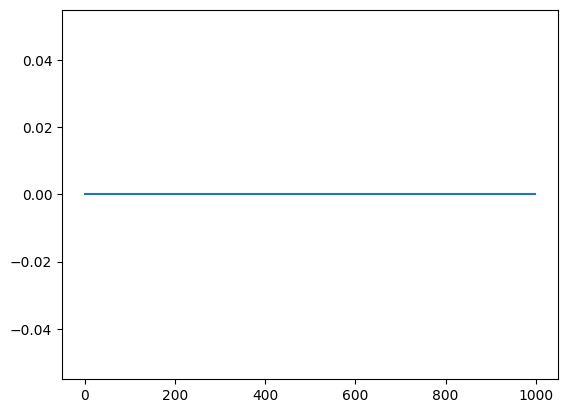

In [19]:
plt.plot(list(range(len(best_value))), best_value, label='Генетичний алгоритм')

In [20]:
res = []
for i in range(len(ii)):
    res.append(int(mw // ii[i, 0])+1)
mlres = 1
for a in res:
    mlres *= a
print(f"{mlres:_}, {len(str(mlres))}")

86_762_353_606_963_200_000_000_000_000_000_000_000, 38


## Anealing

In [10]:
max_weight = mw
items = ii

print("Предмети (вага, вартість):")
for i, item in enumerate(items):
    print(f"Предмет {i+1}: {item}")

sa_solver = SA(items, max_weight, initial_temp=200, cooling_rate=0.999, iterations=100_000)

best_solution, best_value_history = sa_solver.run()

# Обчислення ваги рішення
total_weight = best_solution @ items[..., 0]

print("\nНайкращий розв'язок:")
print(f"Загальна вартість: {best_value_history[-1]}")
print(f"Загальна вага: {total_weight}/{max_weight}")
print("Вибрані предмети:", best_solution)

Предмети (вага, вартість):
Предмет 1: [3 2]
Предмет 2: [2 2]
Предмет 3: [3 2]
Предмет 4: [2 3]
Предмет 5: [3 2]
Предмет 6: [3 1]
Предмет 7: [2 3]
Предмет 8: [2 1]
Предмет 9: [3 2]
Предмет 10: [1 1]
Предмет 11: [1 1]
Предмет 12: [1 2]
Предмет 13: [3 3]
Предмет 14: [3 2]
Предмет 15: [1 3]
Предмет 16: [3 2]
Предмет 17: [3 1]
Предмет 18: [1 3]
Предмет 19: [2 1]
Предмет 20: [2 1]
Предмет 21: [3 2]
Предмет 22: [2 1]
Предмет 23: [3 3]
Предмет 24: [1 3]
Предмет 25: [2 1]
Предмет 26: [2 1]
Предмет 27: [2 1]
Предмет 28: [1 1]
Предмет 29: [3 2]
Предмет 30: [3 2]
Предмет 31: [1 1]
Предмет 32: [3 1]
Предмет 33: [3 2]
Предмет 34: [2 3]
Предмет 35: [2 3]
Предмет 36: [1 1]
Предмет 37: [1 1]
Предмет 38: [3 3]
Предмет 39: [3 3]
Предмет 40: [3 1]
Предмет 41: [3 1]
Предмет 42: [3 1]
Предмет 43: [3 3]
Предмет 44: [3 1]
Предмет 45: [3 3]
Предмет 46: [2 2]
Предмет 47: [3 1]
Предмет 48: [3 1]
Предмет 49: [1 1]
Предмет 50: [3 2]
Предмет 51: [3 2]
Предмет 52: [2 3]
Предмет 53: [2 1]
Предмет 54: [2 3]
Предмет 55

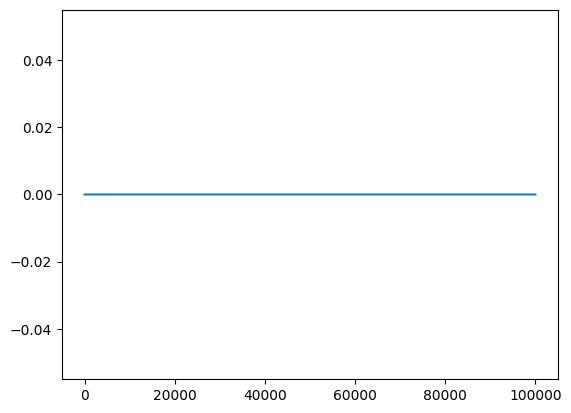

In [11]:
plt.plot(list(range(len(best_value_history))), best_value_history, label='Метод відпалу')